In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

Train_Dir =r'C:\Users\lenovo\Desktop\Kaggle cats vs dogs\train'
Test_Dir = r'C:\Users\lenovo\Desktop\Kaggle cats vs dogs\test'
image_size = 50
lr= 1e-3
Model_Name = 'DogsvsCats-{}-{}.model'.format(lr,'6conv-basic')

In [2]:
def label_image(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return[1,0]
    elif word_label == 'dog': return[0,1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(Train_Dir)):
        label = label_image(img)
        path = os.path.join(Train_Dir,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size,image_size))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(Test_Dir)):
        path = os.path.join(Test_Dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size,image_size))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data = create_train_data()

100%|██████████| 25000/25000 [03:12<00:00, 129.54it/s]


In [14]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, image_size,image_size, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
  
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [13]:
if os.path.exists('{}.meta'.format(Model_Name)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [9]:
train = train_data[:-500]
test = train_data[-500:]

In [10]:
X = np.array([i[0] for i in train]).reshape(-1,image_size,image_size,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,image_size,image_size,1)
test_y = [i[1] for i in test]

In [29]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=50000, show_metric=True, run_id=Model_Name)

Training Step: 1914  | total loss: 0.41432 | time: 54.737s
| Adam | epoch: 005 | loss: 0.41432 - acc: 0.8013 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.41378 | time: 55.882s
| Adam | epoch: 005 | loss: 0.41378 - acc: 0.8008 | val_loss: 0.50166 - val_acc: 0.7720 -- iter: 24500/24500
--


In [30]:
model.save(Model_Name)

INFO:tensorflow:C:\Users\lenovo\DogsvsCats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:21<00:00, 595.05it/s]


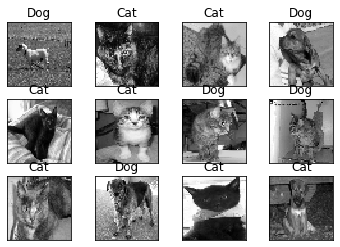

In [33]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(image_size,image_size,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [34]:
with open('submission_file1.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file1.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(image_size,image_size,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:50<00:00, 248.24it/s]
